# Driver Drowsiness CNN Model

In [31]:
# standard
#import cv2
import numpy as np
import pandas as pd
import os
import json
import csv
import random
import string
import shutil

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping

# Enable eager execution for TensorFlow data functions
tf.data.experimental.enable_debug_mode()
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten
from keras import metrics
from keras.utils import vis_utils
tf.get_logger().setLevel('INFO')
tf.config.run_functions_eagerly(True)

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
sns.set(style="darkgrid")  # default style
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


np.random.seed(0)

``Pre-processing: Create combined file directory``


In [32]:
# base data directory
base_dir = '../../207_project_files/data/'

In [33]:
# randomize file names
np.random.seed(0)

def randomize_file_names (dir_path, mapping_file_name, true_labels=True):

  # create a list of all the files in the directory
  files = os.listdir(dir_path)

  # create a dictionary to store the new file names
  file_mapping = {}

  #print("files directory: ", files)
  # loop through each file in the directory
  for file in files:
      #print("file: ",file)
      if file.lower().endswith(('.jpeg', '.jpg', '.png')):
        # generate a random string of 10 characters
        new_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
        # get the file extension
        ext = os.path.splitext(file)[1]
        # create the new file name with the random string and the original file extension
        new_file_name = new_name + ext
        # rename the file
        os.rename(os.path.join(dir_path, file), os.path.join(dir_path, new_file_name))
        
        # add the old and new file names to the dictionary
        #file_mapping[file] = new_file_name
        
        if true_labels:  
          #file_mapping[file] = 1
          label = 1
        else:
          #file_mapping[file] = 0
          label = 0

          # Create a nested dictionary to store old file name, new file name, and label
        file_mapping[file] = {
            'old_file_name': file,
            'new_file_name': new_name,
            'label': label
        }
         
  #print(mapping_file_name)
      
  # write the file mapping to a csv file
  with open(mapping_file_name, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['img_name', 'drowsiness'])
      
      for key, nested_dict in file_mapping.items():
          #print("old file name: ",key,"\tnew file name:",nested_dict['new_file_name'],"\tlabel:",nested_dict['label'])
          #base_name, _ = os.path.splitext(key)
          new_name = nested_dict['new_file_name']
          label = nested_dict['label']
          #print("old file name: ",base_name,"\tnew file name: ",new_file_name)
          #print("old file name: ",base_name,"\tnew file name: ",new_file_name)
          writer.writerow([new_name, label])

# Generate CSV to keep track of postives
randomize_file_names (base_dir + "/Drowsy/", base_dir + 'labels_pos.csv', true_labels=True)

# Generate CSV to keep track of negatives
randomize_file_names (base_dir + "/NonDrowsy/", base_dir + 'labels_neg.csv', true_labels=False)


In [34]:
# Create labels file

# Open the output CSV file in write mode
with open(base_dir + '/labels.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    # Write the header from the first file (assuming both files have the same structure)
    with open(base_dir + 'labels_pos.csv', 'r') as infile1:
        reader1 = csv.reader(infile1)
        header1 = next(reader1)
        writer.writerow(header1)

    rows1 = [row for row in csv.reader(open(base_dir + 'labels_pos.csv', 'r'))]

    # Store rows from the second file in a list
    rows2 = [row for row in csv.reader(open(base_dir + 'labels_neg.csv', 'r'))]

    # Combine the rows from both files
    all_rows = rows1[1:] + rows2[1:]  # Skip the header row

    # Shuffle the combined rows
    #random.shuffle(all_rows)

    # Write the shuffled rows to the output CSV file
    for row in all_rows:
        writer.writerow(row)


In [35]:
combined_dir = os.path.join(base_dir, 'combined')
print(combined_dir)

# create the combined directory if it doesn't already exist
#combined_dir = base_dir + 'combined'
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# Delete all files in the combined directory
file_list = os.listdir(combined_dir)
for file_name in file_list:
    file_path = os.path.join(combined_dir, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)

../../207_project_files/data/combined


In [36]:

# copy all files base_dir/Drowsy to combined_dir
drowsy_dir = os.path.join(base_dir, 'Drowsy')
for file_name in os.listdir(drowsy_dir):
    file_path = os.path.join(drowsy_dir, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, combined_dir)

# copy all files base_dir/NonDrowsy to combined dir
non_drowsy_dir = os.path.join(base_dir, 'NonDrowsy')
for file_name in os.listdir(non_drowsy_dir):
    file_path = os.path.join(non_drowsy_dir, file_name)
    if os.path.isfile(file_path):
        shutil.copy(file_path, combined_dir)

In [37]:
# Keep only .png or jpeg files

# Iterate over files in the directory
for file_name in os.listdir(combined_dir):
    file_path = os.path.join(combined_dir, file_name)

    # Check if the file is a regular file and does not end with '.png' or '.jpeg'
    if os.path.isfile(file_path) and not (file_name.endswith('.png') or file_name.endswith('.jpeg')):
        os.remove(file_path)  # Delete the file

### Read Data for Y labels

In [38]:
# Ready labels
y = pd.read_csv(
    base_dir + 'labels.csv'
)

print(y)
print(y.shape)

       img_name  drowsiness
0    QIOHHJQXAT           1
1    E9J1EUU9K2           1
2    VN38IX7ZT5           1
3    51ZXAZ7RWO           1
4    4371QQRZA6           1
..          ...         ...
365  U1JU2Q8L86           0
366  TBCUS8JR4I           0
367  JXKI0DJ3AK           0
368  49SOP9ZMAB           0
369  6BMLWKOZ7L           0

[370 rows x 2 columns]
(370, 2)


In [39]:
y.shape

(370, 2)

In [40]:

y

,img_name,drowsiness
0,QIOHHJQXAT,1
1,E9J1EUU9K2,1
2,VN38IX7ZT5,1
3,51ZXAZ7RWO,1
4,4371QQRZA6,1
...,...,...
365,U1JU2Q8L86,0
366,TBCUS8JR4I,0
367,JXKI0DJ3AK,0
368,49SOP9ZMAB,0


``Pre-process Data: correcting for data imbalances ``

In [41]:

np.random.seed(0)
sample_size = 150

non_drowsy = y[y.drowsiness == 0]
drowsy = y[y.drowsiness == 1]

# randomly draw images from each classe
non_drowsy_list = list(np.random.choice(
    non_drowsy.img_name,
    size=sample_size,
    replace=False
))

drowsy_list = list(np.random.choice(
    drowsy.img_name,
    size=sample_size,
    replace=False
))

In [42]:
# inspect first five non drowsy results
non_drowsy_list[:5]

['UJ0H0L0UXJ', 'H9HD7SELE0', 'KNZ8QQRYJI', 'Q6DBSBG2XI', 'OCTGES41WJ']

In [43]:
# inspect first five drowsy results
drowsy_list[:5]

['2KNNHDUNM8', 'PR3BZYXZ8S', 'GACOKZWLJA', '0I2FOQNOPA', '6G6NEQ2UXI']

In [44]:
# set image resolutions
X_RES = 80
Y_RES = 80

In [45]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        # read labels
        if img.split('.')[0] in non_drowsy_list:
                y_mini.append(0)
        elif img.split('.')[0] in drowsy_list:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(X_RES, Y_RES)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [46]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(combined_dir +"/", base_dir)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (300, 80, 80, 3)
y_mini shape (300,)


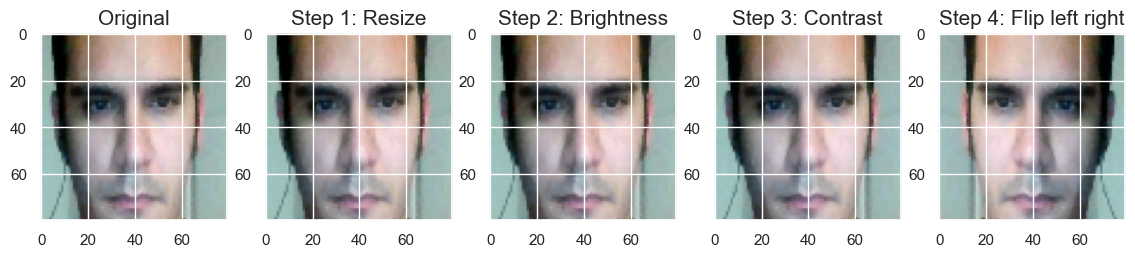

In [47]:
tf.random.set_seed(0)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(X_RES, Y_RES))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [48]:
IMAGE_SIZE = (X_RES, Y_RES)
CONTRAST_FACTOR = 3
DELTA = 0.3
flip = 'yes'


def preprocess_data_part2(images, y, split=(0.6,0.2,0.2), normalize=True):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(0)
    np.random.seed(0)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    #splits = np.multiply(len(images_mini), split).astype(int)
    splits = np.multiply(len(y), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    #X_train, X_val, X_test = np.split(y, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    if normalize:
        X_train = X_train/255.0
        X_val = X_val/255.0
        X_test = X_test/255.0
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # flip image
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

``Create Train + validation and test data ``


In [49]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.8,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (480, 80, 80, 3)
y_train shape (480,)
X_val shape (60, 80, 80, 3)
y_val shape (60,)
X_test shape (0, 80, 80, 3)
y_test shape (0,)


In [50]:
# Plot Function
# empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])


### Base Model

``Build + Compile Model``

In [51]:
# build CNN model

def build_model2 (train_model=False):
    
    """ Buld tf.keras CNN model """
    
    # clear session and remove randomness to get reproducible results
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
    model = keras.Sequential()

    # convolution layer 1
    model.add(Conv2D(filters=16, 
                     kernel_size=(3,3),
                     strides=(1,1), 
                     padding='same',
                     data_format='channels_last',
                     name='conv_1',
                     input_shape=(Y_RES, X_RES, 3), 
                     activation='relu')) 
    
    # add max pooling to L1                 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        name='pool_1'))

    # convolution layer 2
    model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     strides=(1,1),
                     padding='same',
                     name='conv_2',
                     activation='relu'))
    
    # add max pooling to L2             
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        name='pool_2'))

    # if train_model:
    #     model.add(Dropout(0.2))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(Flatten())
    model.add(Dense(units=384,
                    name='fc_1',
                    activation='relu'))
    
    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=0.5
    ))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    
    # output layer
    #model.add(Dense(2, activation='softmax'))
    #model.add(Dense(2, activation='sigmoid'))
    #model.add(Dense(1, activation='softmax'))
    model.add(Dense(1, activation=None))

    # Choose loss function
    # if opt == 'Adam':
    #     optimizer = keras.optimizers.Adam(learning_rate=lr)
    # elif opt == 'Adagrad':
    #     optimizer = keras.optimizers.Adagrad(learning_rate=lr)
    # else:
    #     optimizer = keras.optimizers.SGD(learning_rate=lr)

    #build model and print summary
    #tr.random.set_seed(0)

    
    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy']) 

    return model


In [52]:
# build model instance

# model = build_model2(train_model=True)

# kernel size: 5,5; 3,3
# kernel size: 2,2; 1,1
# pool size: 3,3; 2,2
# lr: 0.01, 0.001
# brightness (delta): 
# contrast factor (delta): 

#model.summary()

``Fit model``

In [53]:
# history = model.fit(
#           x=X_train, 
#           y=y_train,
#           epochs=10,
#           validation_data=(X_val, y_val),
#           verbose=1
#     )

In [54]:
def plot_history(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

In [55]:
n = 5
#init_learning_rate = 0.00420
init_learning_rate = 0.001
learning_rates = []
learning_rates.append(init_learning_rate)

for n in range(1,4):
    #print(n)
    new_lr = init_learning_rate + (n * 0.005)
    #print(new_lr)
    learning_rates.append(new_lr)

print(learning_rates)


[0.001, 0.006, 0.011, 0.016]


### Experimental Model

In [56]:

#optimizers = ['Adam', 'Adagrad', 'SGD']
optimizers = ['Adam']
#learning_rates = [0.00426]
#learning_rates = [0.001]
#learning_rates = [0.00423, 0.004]
kernel_sizes = [(1,1), (2,2)]
#kernel_sizes = [(1,1), (2,2), (3,3)]
#kernel_sizes = [(1,1), (2,2)]
#kernel_sizes = [(1,1)]
drop_rate = [0.5]
stride_sizes = [(1,1)]
pool_sizes = [(1,1), (2,2)]
#pool_sizes = [(1,1)]
epoch_num = 20

In [57]:
# # build CNN model - test

# def build_model (train_model=False, 
#                  lr=0.001, 
#                  opt='Adam', 
#                  k_size=(3,3), 
#                  str_size=(1,1),
#                  p_size=(2,2),
#                  drop_rate=0.5,
#                  batch_norm=False
#                  ):
    
#     """ Buld tf.keras CNN model """
    
#     # clear session and remove randomness to get reproducible results
#     tf.keras.backend.clear_session()
#     tf.random.set_seed(0)
#     np.random.seed(0)

#     model = keras.Sequential()

#     # convolution layer 1
#     model.add(Conv2D(filters=32, 
#                      kernel_size=k_size,
#                      strides=str_size, 
#                      padding='same',
#                      data_format='channels_last',
#                      name='conv_1',
#                      input_shape=(Y_RES, X_RES, 3), 
#                      activation='relu')) 
    
#     # add max pooling to L1                 
#     model.add(tf.keras.layers.MaxPool2D(
#         pool_size=p_size,
#         name='pool_1'))

#     # convolution layer 2
#     model.add(Conv2D(filters=128,
#                      kernel_size=k_size,
#                      strides=str_size,
#                      padding='same',
#                      name='conv_2',
#                      activation='relu'))
    
#     # add max pooling to L2             
#     model.add(tf.keras.layers.MaxPool2D(
#         pool_size=p_size,
#         name='pool_2'))

#     # # add dropout layer
#     # model.add(tf.keras.layers.Dropout(
#     #     rate=drop_rate
#     # ))

#     # add a fully connected layer (need to flatten the output of the previous layers first)
#     model.add(Flatten())
    
#     # add dropout layer
#     # model.add(tf.keras.layers.Dropout(
#     #     rate=drop_rate
#     # ))

#     model.add(Dense(units=384,
#                     name='fc_1',
#                     activation='relu'))
    
#     #add dropout layer
#     model.add(tf.keras.layers.Dropout(
#         rate=drop_rate
#     ))
    
#     model.add(Dense(units=128, 
#                     name="fc_2",
#                     activation='relu'))
    
#     # Add Batch Normalization layer
#     if batch_norm:
#         model.add(tf.keras.layers.BatchNormalization())
    
#     model.add(Dense(units=32, name="fc_3",
#                     activation='relu'))
    
#     # Add Batch Normalization layer
#     if batch_norm:
#         model.add(tf.keras.layers.BatchNormalization())

#     #model.add(Dense(units=16, name="fc_4",
#     #                 activation='relu'))
#     #model.add(tf.keras.layers.Activation('relu'))
    
#     # output layer
#     model.add(Dense(units=1, 
#                     name="fc_4",
#                     activation=None))

#     # loss function
#     if opt == 'Adam':
#         optimizer = keras.optimizers.Adam(learning_rate=lr)
#     elif opt == 'Adagrad':
#         optimizer = keras.optimizers.Adagrad(learning_rate=lr)
#     else:
#         optimizer = keras.optimizers.SGD(learning_rate=lr)
    
#     # Compile model
#     model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#               metrics=['accuracy'])
    
#     vis_utils.plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)
    
#     return model

In [58]:
# colab version

# build CNN model

def build_model (train_model=False, 
                 lr=0.001, 
                 opt='Adam', 
                 k_size=(3,3), 
                 str_size=(1,1),
                 p_size=(2,2),
                 drop_rate=0.5,
                 batch_norm=False
                 ):
    
    """ Buld tf.keras CNN model """
    
    # clear session and remove randomness to get reproducible results
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)

    model = keras.Sequential()

    # convolution layer 1
    model.add(Conv2D(filters=32, 
                     kernel_size=k_size,
                     strides=str_size, 
                     padding='same',
                     data_format='channels_last',
                     name='conv_1',
                     input_shape=(Y_RES, X_RES, 3), 
                     activation='relu')) 
    
    # -----------------------------------------
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(
        rate=drop_rate))
    # -----------------------------------------

    # add max pooling to L1                 
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=p_size,
        name='pool_1'))

    # convolution layer 2
    model.add(Conv2D(filters=128,
                     kernel_size=k_size,
                     strides=str_size,
                     padding='same',
                     name='conv_2',
                     activation='relu'))
    
    # -----------------------------------------
    # Add Batch Normalization layer
    model.add(tf.keras.layers.BatchNormalization())

    # Add the activation layer separately
    model.add(tf.keras.layers.Activation('relu'))
    
    # -----------------------------------------
    # add max pooling to L2             
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=p_size,
        name='pool_2'))

    # dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=drop_rate
    ))

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(Flatten())

    model.add(Dense(units=128,
                    name='fc_1',
                    activation='relu'))
    
    #add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate=drop_rate
    ))
    
    model.add(Dense(units=64, 
                    name="fc_2",
                    activation='relu'))
    
    # Add Batch Normalization layer
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(Dense(units=32, name="fc_3",
                    activation='relu'))
    
    # Add Batch Normalization layer
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    
    # output layer
    model.add(Dense(units=1, 
                    name="fc_4",
                    activation=None))

    # loss function
    if opt == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    elif opt == 'Adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=lr)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # Compile model
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])
    
    vis_utils.plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)
    
    return model

----- model 0 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 8s 304ms/step - loss: 0.8205 - accuracy: 0.5146 - val_loss: 0.6892 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 7s 298ms/step - loss: 0.6887 - accuracy: 0.5750 - val_loss: 0.6890 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 7s 299ms/step - loss: 0.6986 - accuracy: 0.5604 - val_loss: 0.6828 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 7s 303ms/step - loss: 0.6565 - accuracy: 0.5813 - val_loss: 0.6984 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 7s 299ms/step - loss: 0.6140 - accuracy: 0.6250 - val_loss: 0.7077 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 7s 300ms/step - loss: 0.5241 - accuracy: 0.7146 - val_loss: 0.6983 - val_accuracy: 0.4167
Epoch

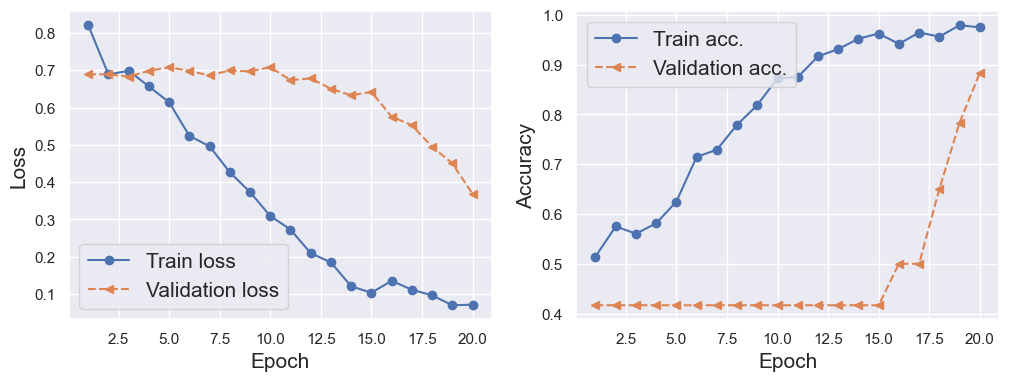



----- model 1 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 77ms/step - loss: 0.8198 - accuracy: 0.5417 - val_loss: 0.6952 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 2s 72ms/step - loss: 0.7152 - accuracy: 0.5542 - val_loss: 0.7037 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 74ms/step - loss: 0.6321 - accuracy: 0.6354 - val_loss: 0.7002 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 75ms/step - loss: 0.6427 - accuracy: 0.6313 - val_loss: 0.7496 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 73ms/step - loss: 0.5838 - accuracy: 0.6729 - val_loss: 0.7409 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 2s 73ms/step - loss: 0.4816 - accuracy: 0.7417 - val_loss: 0.7779 - val_accuracy: 0.4167
Epoch 7/2

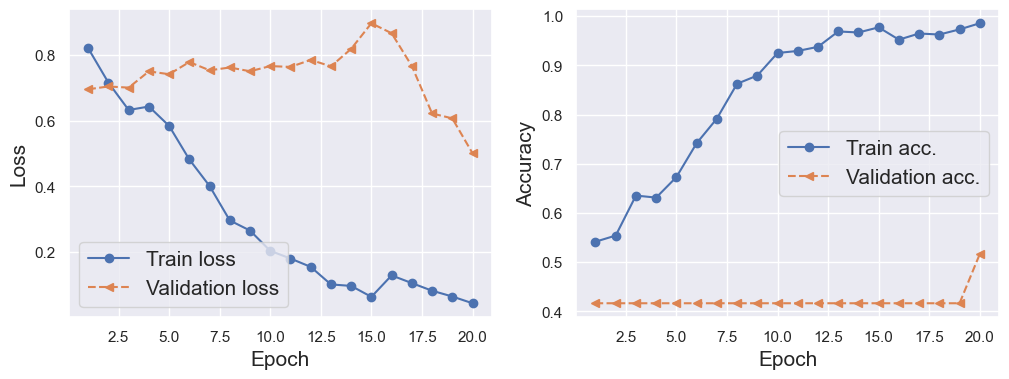



----- model 2 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 10s 401ms/step - loss: 0.8492 - accuracy: 0.5000 - val_loss: 0.6790 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 9s 394ms/step - loss: 0.7415 - accuracy: 0.5437 - val_loss: 0.6797 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 9s 388ms/step - loss: 0.7259 - accuracy: 0.5542 - val_loss: 0.6764 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 9s 384ms/step - loss: 0.6713 - accuracy: 0.5854 - val_loss: 0.6815 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 9s 385ms/step - loss: 0.6626 - accuracy: 0.5646 - val_loss: 0.6773 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 9s 389ms/step - loss: 0.6228 - accuracy: 0.6625 - val_loss: 0.6789 - val_accuracy: 0.4167
Ep

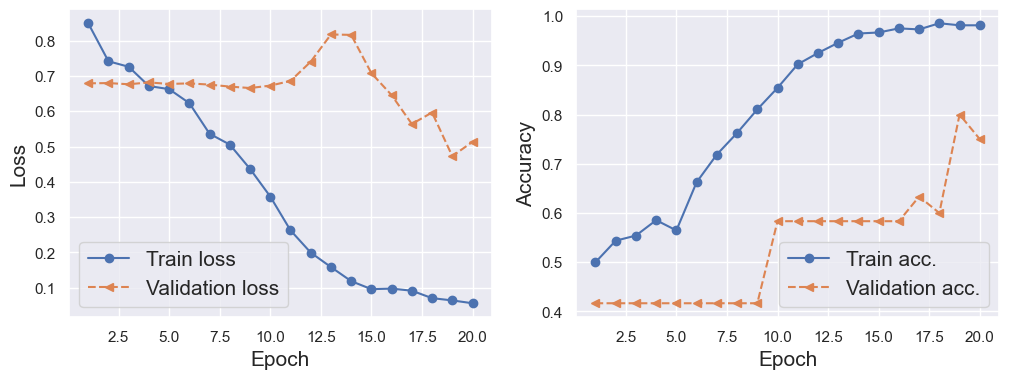



----- model 3 ------
Optimizer:  Adam 	Learning Rate:  0.001 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 3s 103ms/step - loss: 0.8129 - accuracy: 0.5312 - val_loss: 0.6793 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 2s 100ms/step - loss: 0.7193 - accuracy: 0.5771 - val_loss: 0.6789 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 101ms/step - loss: 0.6698 - accuracy: 0.6104 - val_loss: 0.6833 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 99ms/step - loss: 0.6209 - accuracy: 0.6583 - val_loss: 0.7048 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 101ms/step - loss: 0.5276 - accuracy: 0.7125 - val_loss: 0.6932 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 2s 101ms/step - loss: 0.4603 - accuracy: 0.7583 - val_loss: 0.6826 - val_accuracy: 0.4167
Epoc

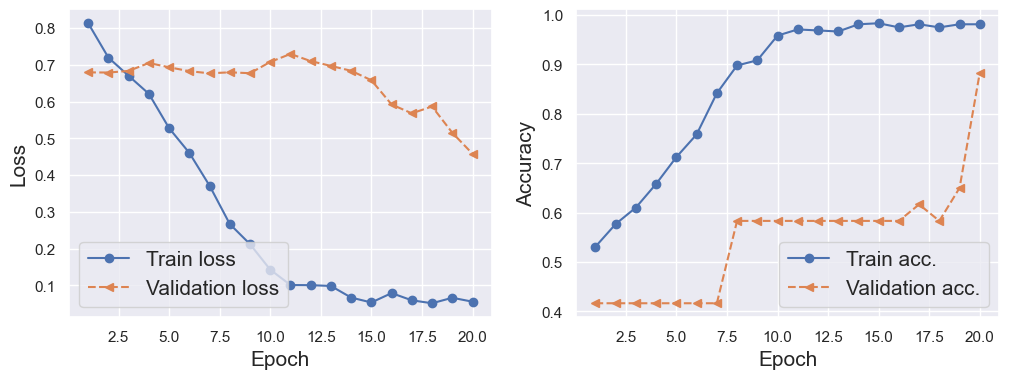



----- model 4 ------
Optimizer:  Adam 	Learning Rate:  0.006 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 8s 305ms/step - loss: 0.8128 - accuracy: 0.5042 - val_loss: 0.6850 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 7s 303ms/step - loss: 0.6824 - accuracy: 0.5583 - val_loss: 0.6892 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 7s 304ms/step - loss: 0.6542 - accuracy: 0.5792 - val_loss: 0.6850 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 7s 275ms/step - loss: 0.5501 - accuracy: 0.7042 - val_loss: 0.7219 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 6s 258ms/step - loss: 0.4079 - accuracy: 0.7667 - val_loss: 0.6850 - val_accuracy: 0.5833
Epoch 6/20
24/24 [==============================] - 6s 255ms/step - loss: 0.2602 - accuracy: 0.8917 - val_loss: 0.6353 - val_accuracy: 0.7833
Epo

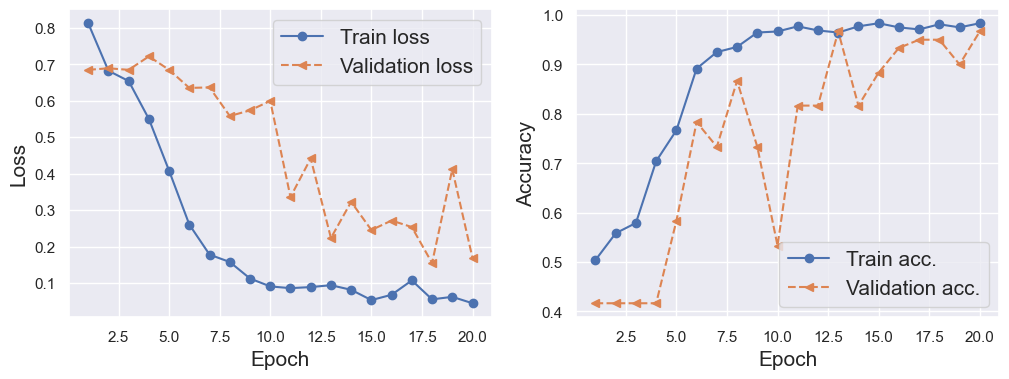



----- model 5 ------
Optimizer:  Adam 	Learning Rate:  0.006 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 63ms/step - loss: 0.8094 - accuracy: 0.5312 - val_loss: 0.7046 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 1s 62ms/step - loss: 0.6833 - accuracy: 0.5500 - val_loss: 0.7401 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 1s 61ms/step - loss: 0.6534 - accuracy: 0.6271 - val_loss: 0.7441 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 1s 62ms/step - loss: 0.5820 - accuracy: 0.6833 - val_loss: 0.7900 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 64ms/step - loss: 0.4317 - accuracy: 0.7771 - val_loss: 0.6751 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 1s 60ms/step - loss: 0.2801 - accuracy: 0.8729 - val_loss: 0.7774 - val_accuracy: 0.4167
Epoch 7/2

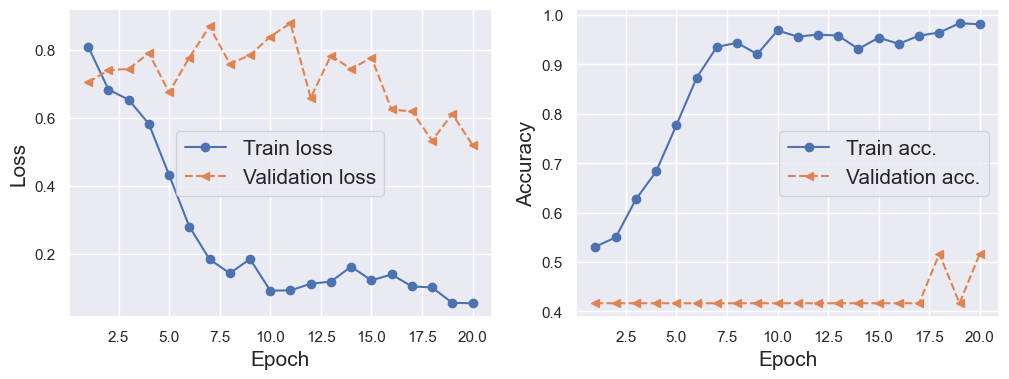



----- model 6 ------
Optimizer:  Adam 	Learning Rate:  0.006 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 8s 330ms/step - loss: 0.7938 - accuracy: 0.5208 - val_loss: 0.6828 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 8s 336ms/step - loss: 0.7109 - accuracy: 0.5396 - val_loss: 0.6816 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 8s 333ms/step - loss: 0.6747 - accuracy: 0.5625 - val_loss: 0.6685 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 8s 334ms/step - loss: 0.5828 - accuracy: 0.6521 - val_loss: 0.6669 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 8s 323ms/step - loss: 0.4748 - accuracy: 0.7333 - val_loss: 0.7131 - val_accuracy: 0.5833
Epoch 6/20
24/24 [==============================] - 8s 326ms/step - loss: 0.2991 - accuracy: 0.8813 - val_loss: 0.8075 - val_accuracy: 0.5833
Epo

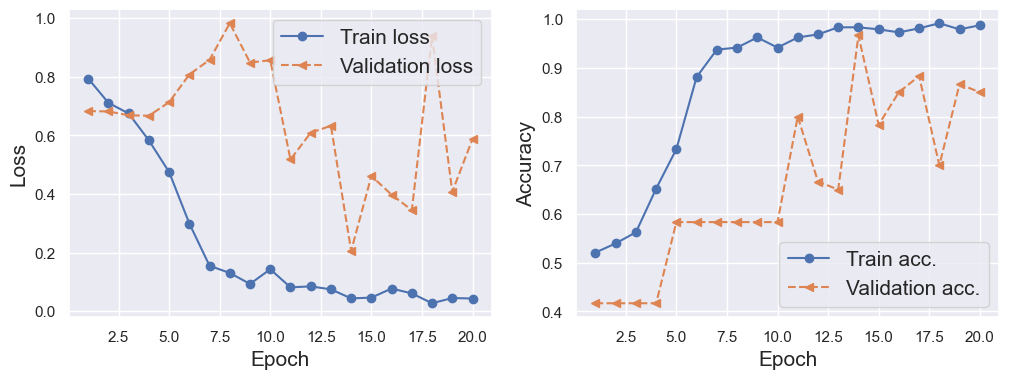



----- model 7 ------
Optimizer:  Adam 	Learning Rate:  0.006 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 83ms/step - loss: 0.8069 - accuracy: 0.5250 - val_loss: 0.6835 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 2s 81ms/step - loss: 0.7329 - accuracy: 0.5312 - val_loss: 0.6811 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 84ms/step - loss: 0.7080 - accuracy: 0.5250 - val_loss: 0.6786 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 82ms/step - loss: 0.6550 - accuracy: 0.5813 - val_loss: 0.6788 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 82ms/step - loss: 0.5936 - accuracy: 0.6354 - val_loss: 0.6857 - val_accuracy: 0.6000
Epoch 6/20
24/24 [==============================] - 2s 81ms/step - loss: 0.4937 - accuracy: 0.7667 - val_loss: 0.7210 - val_accuracy: 0.5833
Epoch 7/2

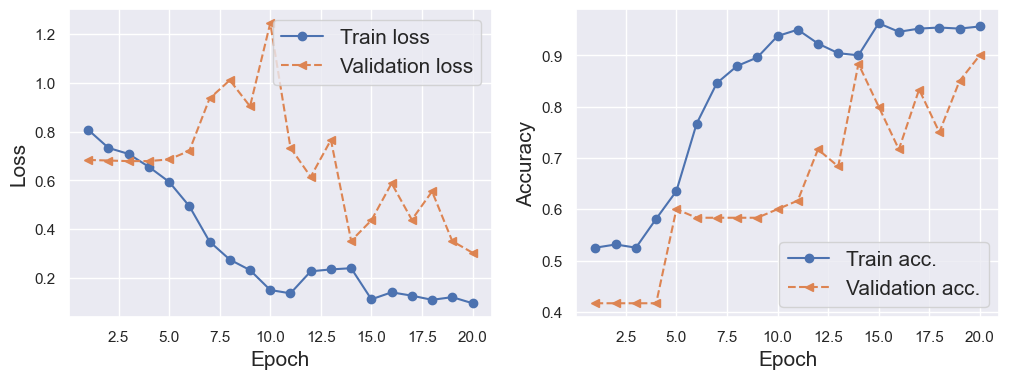



----- model 8 ------
Optimizer:  Adam 	Learning Rate:  0.011 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 7s 255ms/step - loss: 0.8054 - accuracy: 0.5271 - val_loss: 0.6758 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 6s 258ms/step - loss: 0.6714 - accuracy: 0.5625 - val_loss: 0.6836 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 6s 256ms/step - loss: 0.6323 - accuracy: 0.6125 - val_loss: 0.6863 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 6s 256ms/step - loss: 0.4849 - accuracy: 0.7542 - val_loss: 0.7701 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 6s 257ms/step - loss: 0.3219 - accuracy: 0.8604 - val_loss: 0.5720 - val_accuracy: 0.7167
Epoch 6/20
24/24 [==============================] - 6s 257ms/step - loss: 0.1900 - accuracy: 0.9208 - val_loss: 0.4989 - val_accuracy: 0.5333
Epo

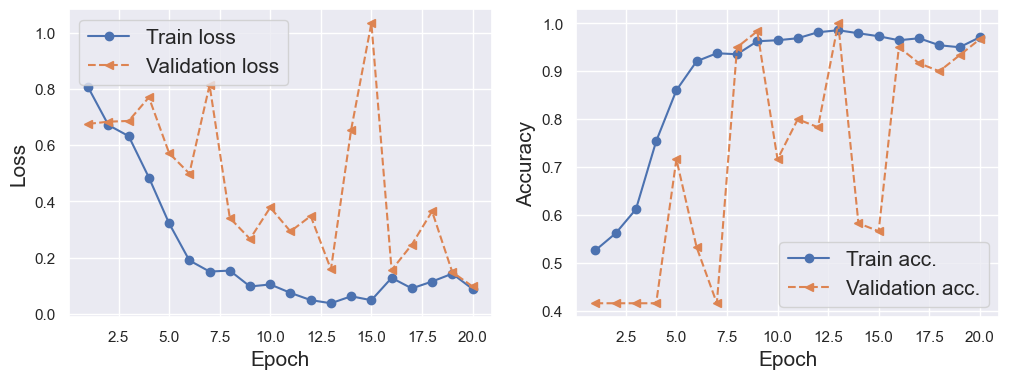



----- model 9 ------
Optimizer:  Adam 	Learning Rate:  0.011 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 67ms/step - loss: 0.8033 - accuracy: 0.5271 - val_loss: 0.6943 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 2s 65ms/step - loss: 0.7000 - accuracy: 0.5542 - val_loss: 0.7182 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 66ms/step - loss: 0.6251 - accuracy: 0.6333 - val_loss: 0.8424 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 64ms/step - loss: 0.5664 - accuracy: 0.6750 - val_loss: 1.2669 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 63ms/step - loss: 0.3846 - accuracy: 0.8250 - val_loss: 0.7884 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 2s 63ms/step - loss: 0.2514 - accuracy: 0.8875 - val_loss: 1.4863 - val_accuracy: 0.4167
Epoch 7/2

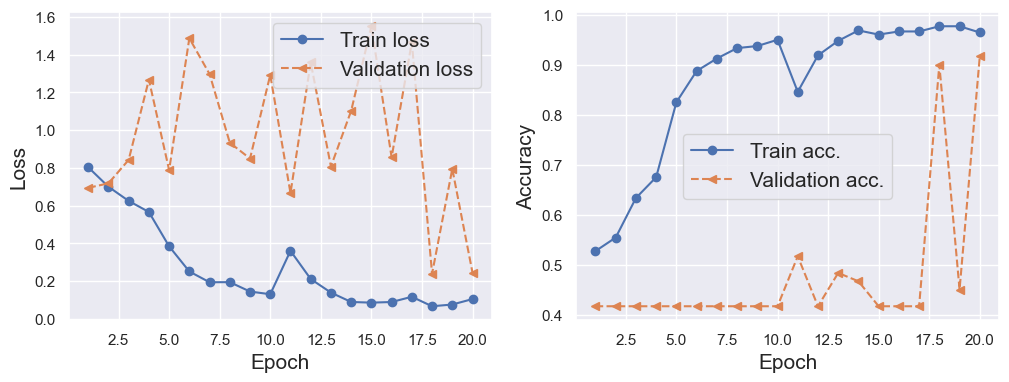



----- model 10 -----
Optimizer:  Adam 	Learning Rate:  0.011 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 9s 347ms/step - loss: 0.7927 - accuracy: 0.5292 - val_loss: 0.6937 - val_accuracy: 0.4000
Epoch 2/20
24/24 [==============================] - 8s 336ms/step - loss: 0.7075 - accuracy: 0.5312 - val_loss: 0.6958 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 8s 327ms/step - loss: 0.6944 - accuracy: 0.5437 - val_loss: 0.6585 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 8s 330ms/step - loss: 0.6594 - accuracy: 0.5625 - val_loss: 0.6345 - val_accuracy: 0.4833
Epoch 5/20
24/24 [==============================] - 8s 330ms/step - loss: 0.5186 - accuracy: 0.6958 - val_loss: 0.6844 - val_accuracy: 0.6500
Epoch 6/20
24/24 [==============================] - 8s 330ms/step - loss: 0.3918 - accuracy: 0.8146 - val_loss: 0.6530 - val_accuracy: 0.6667
Epo

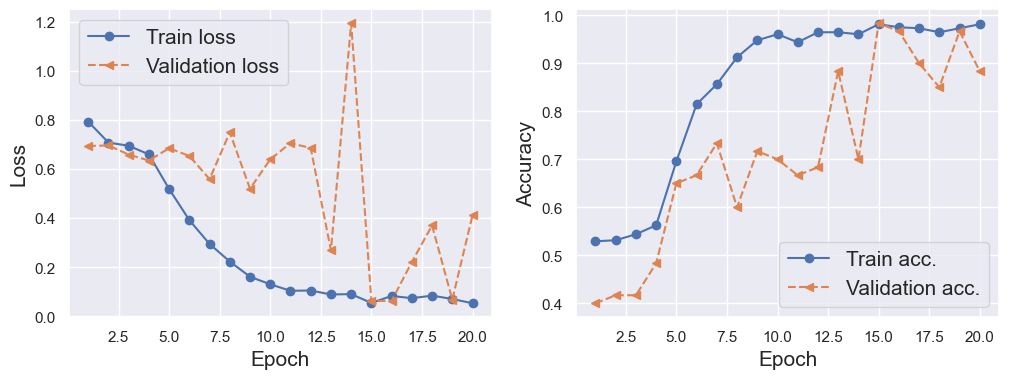



----- model 11 -----
Optimizer:  Adam 	Learning Rate:  0.011 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 87ms/step - loss: 0.7978 - accuracy: 0.5396 - val_loss: 0.6846 - val_accuracy: 0.4333
Epoch 2/20
24/24 [==============================] - 2s 90ms/step - loss: 0.7278 - accuracy: 0.5042 - val_loss: 0.6764 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 88ms/step - loss: 0.6994 - accuracy: 0.5375 - val_loss: 0.6762 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 81ms/step - loss: 0.6816 - accuracy: 0.5417 - val_loss: 0.7410 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 83ms/step - loss: 0.6433 - accuracy: 0.5708 - val_loss: 0.7119 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 2s 83ms/step - loss: 0.5166 - accuracy: 0.7208 - val_loss: 0.9876 - val_accuracy: 0.4167
Epoch 7/2

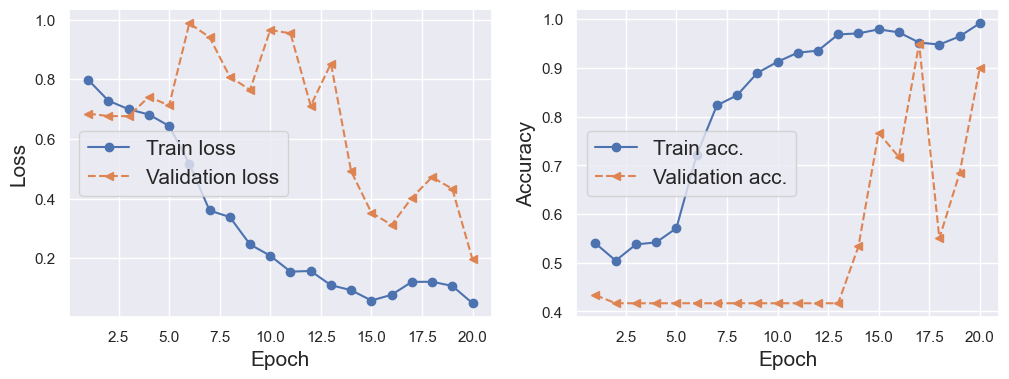



----- model 12 -----
Optimizer:  Adam 	Learning Rate:  0.016 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 7s 261ms/step - loss: 0.8174 - accuracy: 0.4917 - val_loss: 0.6795 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 6s 254ms/step - loss: 0.6948 - accuracy: 0.5437 - val_loss: 0.6788 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 6s 262ms/step - loss: 0.6187 - accuracy: 0.5750 - val_loss: 0.6739 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 6s 255ms/step - loss: 0.5840 - accuracy: 0.6792 - val_loss: 0.7053 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 6s 268ms/step - loss: 0.4382 - accuracy: 0.7771 - val_loss: 0.5801 - val_accuracy: 0.5167
Epoch 6/20
24/24 [==============================] - 6s 259ms/step - loss: 0.2725 - accuracy: 0.8917 - val_loss: 0.4734 - val_accuracy: 0.9000
Epo

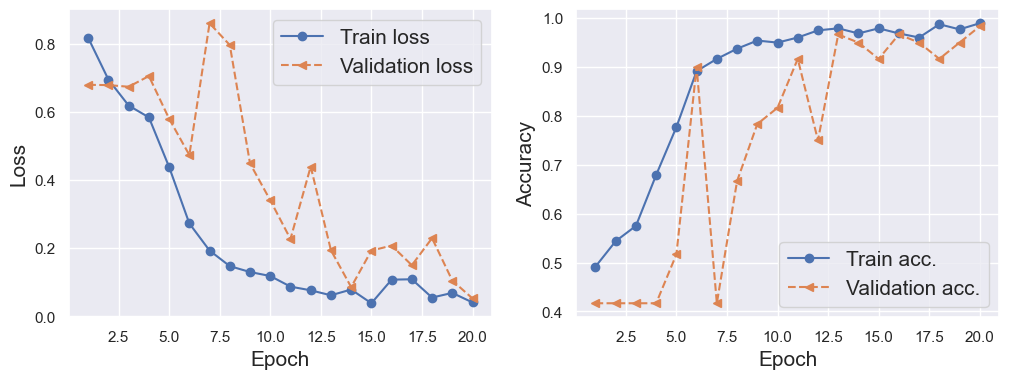



----- model 13 -----
Optimizer:  Adam 	Learning Rate:  0.016 	Kernel Size:  (1, 1) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 66ms/step - loss: 0.7952 - accuracy: 0.5437 - val_loss: 0.6909 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 1s 61ms/step - loss: 0.6840 - accuracy: 0.5708 - val_loss: 0.7529 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 1s 61ms/step - loss: 0.6403 - accuracy: 0.6271 - val_loss: 0.8487 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 1s 62ms/step - loss: 0.5472 - accuracy: 0.7396 - val_loss: 1.3372 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 1s 62ms/step - loss: 0.4129 - accuracy: 0.7979 - val_loss: 0.9588 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 1s 61ms/step - loss: 0.2457 - accuracy: 0.9062 - val_loss: 1.4846 - val_accuracy: 0.4167
Epoch 7/2

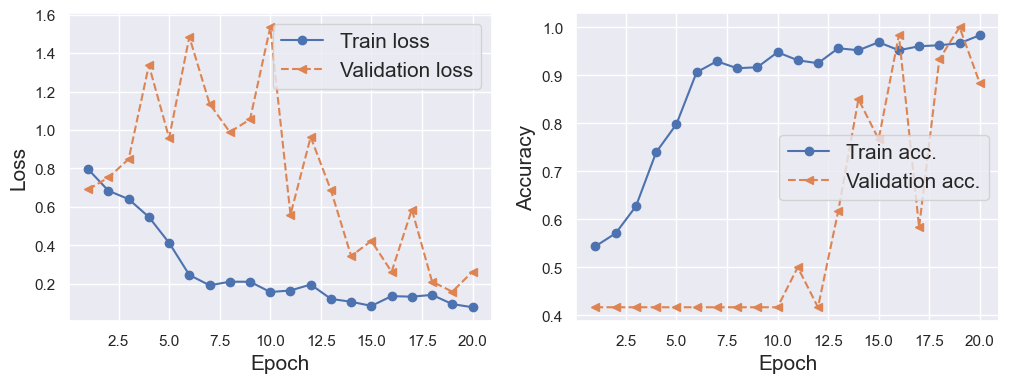



----- model 14 -----
Optimizer:  Adam 	Learning Rate:  0.016 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (1, 1)
Epoch 1/20
24/24 [==============================] - 8s 327ms/step - loss: 0.8170 - accuracy: 0.5000 - val_loss: 0.8244 - val_accuracy: 0.5833
Epoch 2/20
24/24 [==============================] - 8s 326ms/step - loss: 0.7090 - accuracy: 0.5354 - val_loss: 0.6736 - val_accuracy: 0.3833
Epoch 3/20
24/24 [==============================] - 8s 324ms/step - loss: 0.6531 - accuracy: 0.5604 - val_loss: 0.6513 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 8s 324ms/step - loss: 0.6020 - accuracy: 0.6250 - val_loss: 0.6654 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 8s 332ms/step - loss: 0.5371 - accuracy: 0.6875 - val_loss: 0.6009 - val_accuracy: 0.7000
Epoch 6/20
24/24 [==============================] - 8s 327ms/step - loss: 0.3621 - accuracy: 0.8500 - val_loss: 0.3973 - val_accuracy: 0.8333
Epo

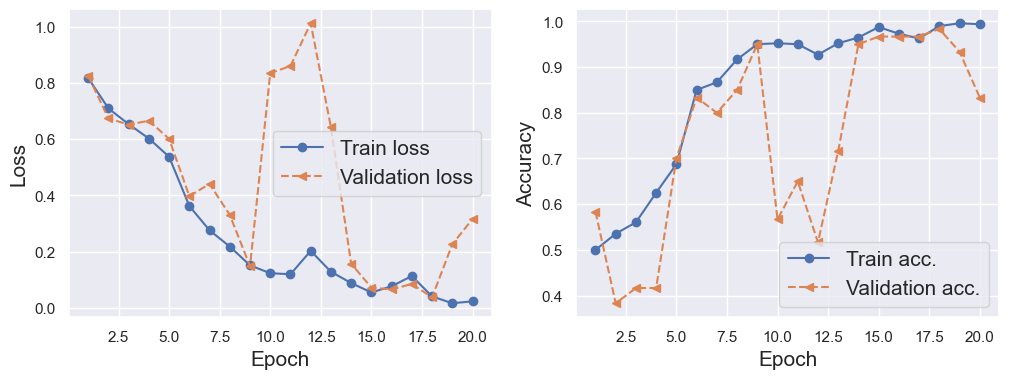



----- model 15 -----
Optimizer:  Adam 	Learning Rate:  0.016 	Kernel Size:  (2, 2) 	Drop out rate: 0.5 	Stride Size: (1, 1) 	Pool Size: (2, 2)
Epoch 1/20
24/24 [==============================] - 2s 85ms/step - loss: 0.8204 - accuracy: 0.5354 - val_loss: 0.6822 - val_accuracy: 0.4167
Epoch 2/20
24/24 [==============================] - 2s 84ms/step - loss: 0.6838 - accuracy: 0.5229 - val_loss: 0.6928 - val_accuracy: 0.4167
Epoch 3/20
24/24 [==============================] - 2s 88ms/step - loss: 0.6754 - accuracy: 0.5896 - val_loss: 0.7081 - val_accuracy: 0.4167
Epoch 4/20
24/24 [==============================] - 2s 82ms/step - loss: 0.6253 - accuracy: 0.6229 - val_loss: 0.9553 - val_accuracy: 0.4167
Epoch 5/20
24/24 [==============================] - 2s 83ms/step - loss: 0.5488 - accuracy: 0.7104 - val_loss: 0.8967 - val_accuracy: 0.4167
Epoch 6/20
24/24 [==============================] - 2s 84ms/step - loss: 0.4078 - accuracy: 0.8292 - val_loss: 0.9015 - val_accuracy: 0.4167
Epoch 7/2

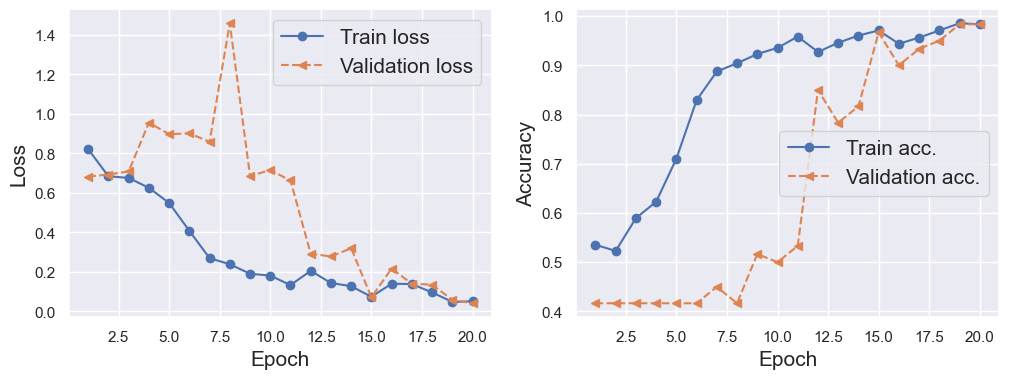

In [59]:
# initialize dictionary for models
models = {}
run_count = 0

for opt in optimizers:
    for lr in learning_rates:
        for ksize in kernel_sizes:
            for rate in drop_rate:
                for stride in stride_sizes:
                    for pool in pool_sizes:

                        tf.random.set_seed(0)
                        np.random.seed(0)

                        # Build model based on params
                        model = build_model(train_model=True,
                                            lr=lr,
                                            opt=opt,
                                            k_size=ksize,
                                            drop_rate=rate,
                                            str_size=stride,
                                            p_size=pool,
                                            batch_norm=True)
                        
                        models[run_count] = model

                        model_run = " model " + str(run_count) + " "
                        print(model_run.center(20,"-"))
                    
                        print("Optimizer: ",opt, "\tLearning Rate: ",lr, "\tKernel Size: ",ksize,
                            "\tDrop out rate:",rate, "\tStride Size:",stride, "\tPool Size:",pool)
                        
                        # Define the EarlyStopping callback
                        early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor (e.g., validation loss)
                               patience=10,          # Number of epochs with no improvement before stopping
                               restore_best_weights=True) 

                        #Fit model
                        history = models[run_count].fit(
                            x=X_train, 
                            y=y_train,
                            epochs=epoch_num,
                            batch_size=20,
                            validation_data=(X_val, y_val),
                            verbose=1#,
                            #callbacks=[early_stopping]
                        )

                        # store each model's training and validation accuracy into dictionary
                        models[run_count] = {'accuracy': history.history['accuracy'][-1:][0],
                                            'val_accuracy': history.history['val_accuracy'][-1:][0],
                                            'params': model.count_params(),
                                            'Loss': opt,
                                            'Learn Rate': lr,
                                            'kernel_size': ksize,
                                            'Dropout rate': rate,
                                            'Stride Size': stride,
                                            'Pool Size': pool,

                                            }
                        
                        print(f"\t\tAccuracy: {history.history['accuracy'][-1:][0]:.4}\tValidation Accuracy: {history.history['val_accuracy'][-1:][0]:.4}")
                        plot_history(history)
                        
                        print("\n")

                        run_count += 1

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 80, 80, 32)        416       
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 80, 32)        0         
                                                                 
 dropout (Dropout)           (None, 80, 80, 32)        0         
                                                                 
 pool_1 (MaxPooling2D)       (None, 40, 40, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 40, 40, 128)       16512     
                                                        

In [61]:
rows = []

for key, accuracy in models.items():
    row = {'Model': key}
    row.update(accuracy)
    rows.append(row)

# build final table
final_counts_table = pd.DataFrame(rows)
final_counts_table

,Model,accuracy,val_accuracy,params,Loss,Learn Rate,kernel_size,Dropout rate,Stride Size,Pool Size
0,0,0.975000,0.883333,104873473,Adam,0.001,"(1, 1)",0.5,"(1, 1)","(1, 1)"
1,1,0.985417,0.516667,6569473,Adam,0.001,"(1, 1)",0.5,"(1, 1)","(2, 2)"
2,2,0.981250,0.750000,104886049,Adam,0.001,"(2, 2)",0.5,"(1, 1)","(1, 1)"
3,3,0.981250,0.883333,6582049,Adam,0.001,"(2, 2)",0.5,"(1, 1)","(2, 2)"
4,4,0.983333,0.966667,104873473,Adam,0.006,"(1, 1)",0.5,"(1, 1)","(1, 1)"
5,5,0.981250,0.516667,6569473,Adam,0.006,"(1, 1)",0.5,"(1, 1)","(2, 2)"
6,6,0.987500,0.850000,104886049,Adam,0.006,"(2, 2)",0.5,"(1, 1)","(1, 1)"
7,7,0.956250,0.900000,6582049,Adam,0.006,"(2, 2)",0.5,"(1, 1)","(2, 2)"
8,8,0.970833,0.966667,104873473,Adam,0.011,"(1, 1)",0.5,"(1, 1)","(1, 1)"
9,9,0.964583,0.916667,6569473,Adam,0.011,"(1, 1)",0.5,"(1, 1)","(2, 2)"


In [62]:
final_counts_table['avg_acc'] = (final_counts_table['accuracy'] + final_counts_table['val_accuracy']) / 2
final_counts_table.sort_values('avg_acc',ascending=False)

,Model,accuracy,val_accuracy,params,Loss,Learn Rate,kernel_size,Dropout rate,Stride Size,Pool Size,avg_acc
12,12,0.989583,0.983333,104873473,Adam,0.016,"(1, 1)",0.5,"(1, 1)","(1, 1)",0.986458
15,15,0.983333,0.983333,6582049,Adam,0.016,"(2, 2)",0.5,"(1, 1)","(2, 2)",0.983333
4,4,0.983333,0.966667,104873473,Adam,0.006,"(1, 1)",0.5,"(1, 1)","(1, 1)",0.975000
8,8,0.970833,0.966667,104873473,Adam,0.011,"(1, 1)",0.5,"(1, 1)","(1, 1)",0.968750
11,11,0.991667,0.900000,6582049,Adam,0.011,"(2, 2)",0.5,"(1, 1)","(2, 2)",0.945833
9,9,0.964583,0.916667,6569473,Adam,0.011,"(1, 1)",0.5,"(1, 1)","(2, 2)",0.940625
13,13,0.983333,0.883333,6569473,Adam,0.016,"(1, 1)",0.5,"(1, 1)","(2, 2)",0.933333
3,3,0.981250,0.883333,6582049,Adam,0.001,"(2, 2)",0.5,"(1, 1)","(2, 2)",0.932292
10,10,0.981250,0.883333,104886049,Adam,0.011,"(2, 2)",0.5,"(1, 1)","(1, 1)",0.932292
0,0,0.975000,0.883333,104873473,Adam,0.001,"(1, 1)",0.5,"(1, 1)","(1, 1)",0.929167


# Model Predictions

In [68]:
base_dir
print(base_dir)

../../207_project_files/data/


1/1 [==============================] - 0s 17ms/step
[[-258.2261]]
1/1 [==============================] - 0s 14ms/step
[[-156.17458]]
1/1 [==============================] - 0s 14ms/step
[[-166.22867]]
1/1 [==============================] - 0s 14ms/step
[[-165.03647]]
1/1 [==============================] - 0s 12ms/step
[[-166.65059]]
1/1 [==============================] - 0s 18ms/step
[[-196.93683]]
1/1 [==============================] - 0s 14ms/step
[[-251.4814]]
1/1 [==============================] - 0s 14ms/step
[[-206.08305]]
1/1 [==============================] - 0s 14ms/step
[[-196.8341]]
1/1 [==============================] - 0s 13ms/step
[[-184.77321]]
1/1 [==============================] - 0s 14ms/step
[[-212.42337]]
1/1 [==============================] - 0s 14ms/step
[[-151.30545]]
1/1 [==============================] - 0s 13ms/step
[[-156.48016]]
1/1 [==============================] - 0s 13ms/step
[[-190.71423]]
1/1 [==============================] - 0s 14ms/step
[[-101.091156

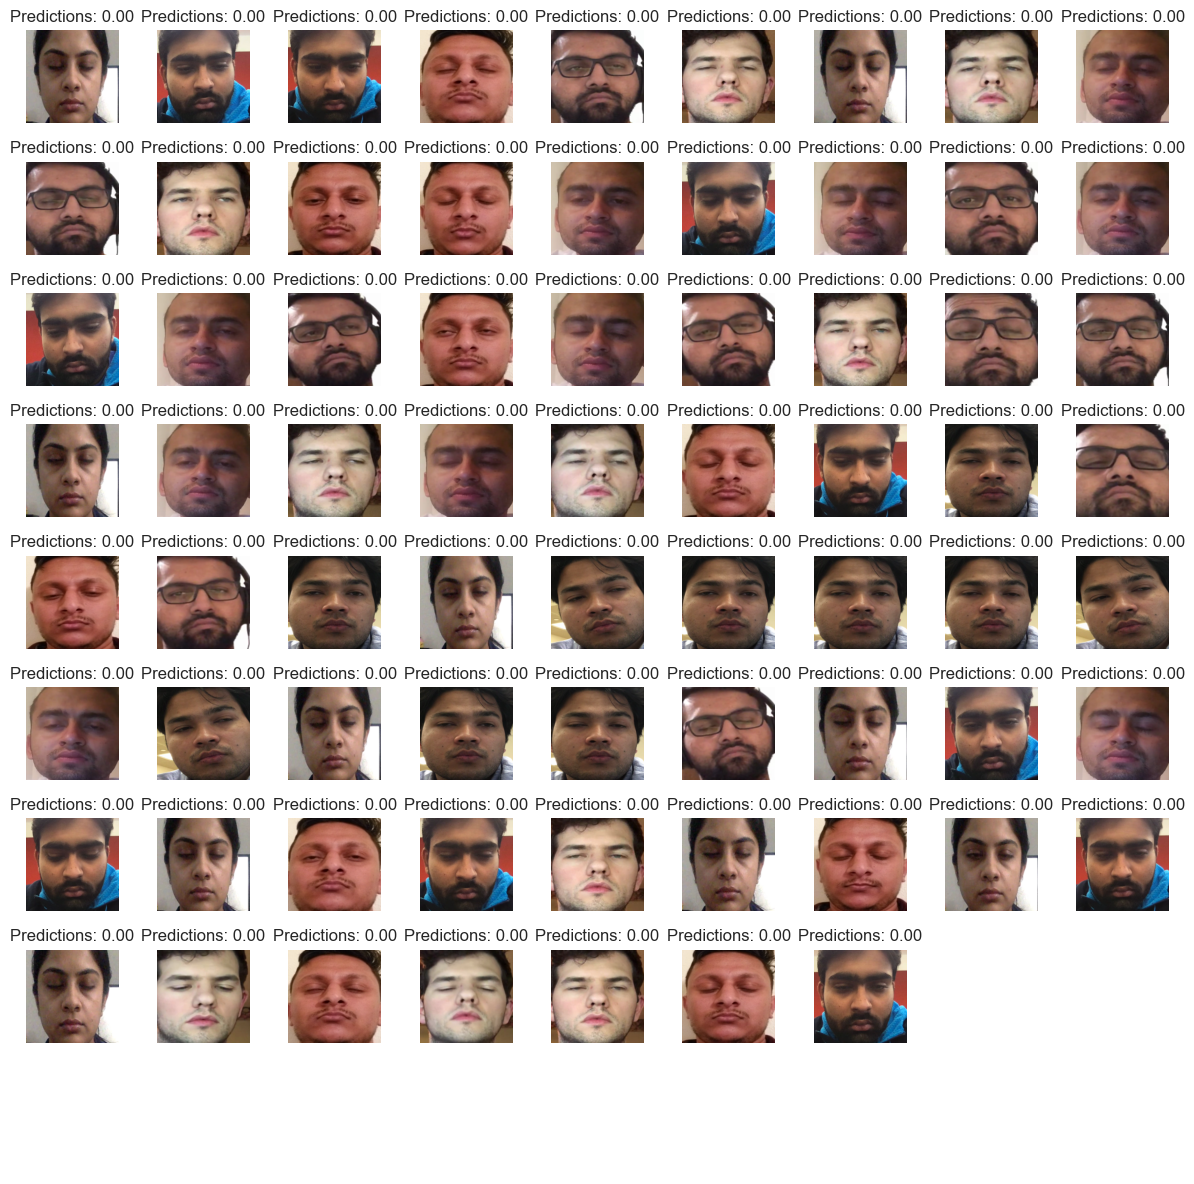

[0.]
1
0
0


In [82]:
from tensorflow import keras
import pandas as pd
import os
from IPython.display import display, Image
import io

def predict(model, img_path):
    img = keras.utils.load_img(
        img_path, target_size=(X_RES, Y_RES))
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)

    return predictions

#dir_path = base_dir + "drowsy/"
dir_path = base_dir + "test_drowsy/"
#dir_path = base_dir + "test_nondrowsy/"


i = 0
file_path = []
prediction_results = []

# Iterate through files in the directory and ignore .DS_Store files
for file_name in os.listdir(dir_path):
    if not file_name.startswith('.'):
        predictions = predict(model, os.path.join(dir_path, file_name))
        print(predictions)
        # Convert logits to probabilities
        probabilities = tf.nn.sigmoid(predictions).numpy()
        prediction_results.append(probabilities[0])
        file_path.append(os.path.join(dir_path, file_name))

data = {'file_path': file_path, 'prediction_results': prediction_results}
df = pd.DataFrame(data)
print(df)

'''
# Display the dataframe with filepath as a link to the image
for index, row in df.iterrows():
    display(Image(filename=row['file_path']))
    print(row)
'''   

# Define the grid size based on the number of images
num_images = len(df)
grid_size = int(num_images ** 0.5) + 1

# Create a grid of subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))


# Iterate over the dataframe rows and display the image with prediction result
for index, row in df.iterrows():
    img = plt.imread(row['file_path'])
    ax = axs[index // grid_size, index % grid_size]
    ax.imshow(img)
    ax.axis('off')
    
    # Convert and display the prediction results
    prediction_results = row['prediction_results']
    formatted_predictions = ", ".join([f"{val:.2f}" for val in prediction_results])
    ax.set_title(f"Predictions: {formatted_predictions}")
    
    #prediction_results = float(row['prediction_results'])
    #ax.set_title(f"Prediction: {row['prediction_results']:.2f}")

# Remove empty subplots
for i in range(num_images, grid_size ** 2):
    axs[i // grid_size, i % grid_size].axis('off')

plt.tight_layout()
plt.show()


print(np.array(prediction_results))
array = np.array(prediction_results)
print(np.size(array))

um_elements_greater_than_zero = np.sum(array > 0)

print (um_elements_greater_than_zero)

um_elements_less_than_zero = np.sum(array < 0)
print (um_elements_less_than_zero)

In [83]:
# from tensorflow import keras
# import pandas as pd
# from IPython.display import display, Image


# def predict(model, img):
#     img= keras.utils.load_img(
#         img, target_size=(X_RES, Y_RES))
#     img_array = keras.utils.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#     predictions = model.predict(img_array)

#     return predictions

# #dir_path = base_dir + "test_nondrowsy/"

# i = 0
# file_path = []
# prediction_results = []
# for file_name in os.listdir(dir_path):
    
#     predictions = predict(model, dir_path+file_name)
    
#     print (predictions)
    
#     # Convert logits to probabilities
#     probabilities = tf.nn.sigmoid(predictions).numpy()
    
#     prediction_results.append(probabilities[0])
#     file_path.append(dir_path+file_name)

# data = {'file_path': file_path, 'prediction_results': prediction_results}
# df = pd.DataFrame(data)


# # Define the grid size based on the number of images
# num_images = len(df)
# grid_size = int(num_images ** 0.5) + 1

# # Create a grid of subplots
# fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))


# # Iterate over the dataframe rows and display the image with prediction result
# for index, row in df.iterrows():
#     img = plt.imread(row['file_path'])
#     ax = axs[index // grid_size, index % grid_size]
#     ax.imshow(img)
#     ax.axis('off')
    
#     # Convert and display the prediction results
#     prediction_results = row['prediction_results']
#     formatted_predictions = ", ".join([f"{val:.2f}" for val in prediction_results])
#     ax.set_title(f"Predictions: {formatted_predictions}")
    
#     #prediction_results = float(row['prediction_results'])
#     #ax.set_title(f"Prediction: {row['prediction_results']:.2f}")

# # Remove empty subplots
# for i in range(num_images, grid_size ** 2):
#     axs[i // grid_size, i % grid_size].axis('off')

# plt.tight_layout()
# plt.show()


# print(np.array(prediction_results))
# array = np.array(prediction_results)
# print(np.size(array))

# um_elements_greater_than_zero = np.sum(array > 0)

# print (um_elements_greater_than_zero)

# um_elements_less_than_zero = np.sum(array < 0)
# print (um_elements_less_than_zero)

In [84]:
# import  pandas as pd
# from IPython.display import display

# #dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'

# #dir_path = '/Users/mayank/Programs/mids_ml/mids/DriverDrowsiness/data/test_img/'
# dir_path = '/Users/mayank/Programs/mids_ml/mids/DriverDrowsiness/data/test_img/'

# def predict(model, img):
#     img= keras.utils.load_img(
#         img, target_size=(X_RES, Y_RES), color_mode='rgb')
#     img_array = keras.utils.img_to_array(img)
#     img_array = img_array / 255.0
#     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#     predictions = model.predict(img_array)

#     return predictions

# i = 0
# prediction_results = []
# for file_name in os.listdir(dir_path):

#     predictions = predict(model, dir_path+file_name)

#     dp, fn = os.path.split(dir_path)
#     prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
#     i = i + 1
#     if i == 100:
#         break

# df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])

# #df = pd.DataFrame(prediction_results, columns=['Filename', '1', '2', '3', '4'])


# display(df)

In [85]:
# import matplotlib.pyplot as plt

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from keras.layers import Conv2D
# from keras.models import Model
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most warnings

# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Suppress TensorFlow v1.x warnings


# def plot_conv_layers(model, img_path):
#     # Load the image
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (X_RES, Y_RES))
#     img = np.expand_dims(img, axis=0)  # Expand dimensions to match model's input shape

#     # Get the output of each Conv2D layer
#     layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
#     activation_model = Model(inputs=model.input, outputs=layer_outputs)

#     # Get activations
#     activations = activation_model.predict(img)
#     layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

#    # Plot the output of each layer in a 1x3 grid
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     for i, ax in enumerate(axes):
#         ax.imshow(activations[i][0, :, :, 0], cmap='gray')  # Displaying the 1st channel
#         ax.set_title(layer_names[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()


# # Plot the convolved layers
# plot_conv_layers(model, '/home/mayank/Pictures/Webcam/test/face_2.jpg')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/d0016.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/c0417.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/b0027.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/a1023.png')